## 1. 들어가며  

- OCR을 처음부터 끝까지 만들기에는 시간이 많이 소요됨  
  -> Detection은 keras-ocr을 활용하고, Recognition은 직접 만들어 학습하기로  
  
#### 실습목표  
1. Text Recognition 모델을 직접 구현해 봅니다.  
2. Text Recognition 모델 학습을 진행해 봅니다.  
3. Text Detection 모델과 연결하여 전체 OCR 시스템을 구현합니다.  

#### 목차  
 1 .Overall sturcture of OCR   
 2. Dataset for OCR  
 3. Recognition model  
    - Input Image  
    - Encode  
    - Build CRNN model  
    - Train & Inference  
   
 4. 프로젝트 : End-to-End OCR  


## 2. Overall structure of OCR  
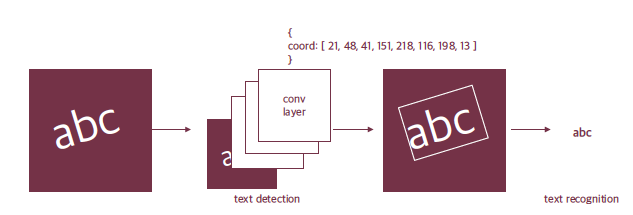  
[카카오 OCR 시스템 구성과 모델](https://brunch.co.kr/@kakao-it/318)  

만들고자 하는 OCR은  
이미지 속에서 영문을 Bounding box로 찾아내고  
그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템  

이미지 속에서 문자 영역을 찾아내는 Text Detection은  
이전에 봤던 방법 중 Segmentation 기반의 CRAFT를 활용한  
**keras-ocr**을 활용할 예정  


**keras-ocr**
- [keras-ocr 공식 github](https://github.com/faustomorales/keras-ocr)  
- [CRAFT: Character Region Awareness for Text detection](https://arxiv.org/pdf/1904.01941.pdf)  
- [CRAFT Pytorch 공식 implementation](https://github.com/clovaai/CRAFT-pytorch)  
- [CRAFT Keras 버전 github](https://github.com/notAI-tech/keras-craft)  

- keras-ocr에서 지원하는 recognition 모델은 어떤 구조?  
  : Convolution layer, RNN 결합 + CTC로 학습된 CRNN 사용  
  
  
- CNN과 RNN의 아이디어를 결합하여  
  Text Recognition의 초기 모델의 뼈대를 완성했던 CRNN 모델도 2015년에 나온 것  
  이후 성능 향상 시키며 다양한 모델 제시됨  
  [2019년에 발표된 Naver Clova 논문:   What Is Wrong With Scene Text Recognition Model Comparisons? Dataset and Model Analysis](https://arxiv.org/pdf/1904.01906.pdf)  
  당시 까지의 모델 발전사 살펴볼 수 있음  
  -> keras-ocr의 CRNN 기반 Recognition 모델과  
  위 논문에 소개된 Recognition에서 가장 높은 성능을 얻은 (저자들의) 모델의 차이점은?  
  : 첫 번째로 입력 이미지 변환 단계에서는  
  모델의 앞에서 글자를 Thin plate spline Transformation을 해주는 TPS 모듈이 붙음  
  마지막 Text 출력 단계에서는  
  Bidirectional LSTM 뒤로 Attention decoder가 붙음  

## 3. Dataset for OCR  
- OCR은 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 하는 번거로움 있음  
  -> 즉 OCR 데이터를 대량으로 만들려면 큰 비용 든다는 것  
  -> 데이터 문제를 해결하기 위한 방법은?  
  -> 컴퓨터로 대량 문자 이미지 데이터를 만들어내는 방법  
  -> 이렇게 직접 문자 데이터를 생성하게 되면  
  원하는 언어를 원하는 폰트와 원하는 배치 및 크기로  
  문자 이미지를 대량으로 만들어낼 수 있다는 장점이 있음  
  
  
- 이전 스텝에서 소개했던 clova 논문들에선  
  Recognition model의 정량적인 평가를 위해  
  -> MJSynth와 SynthText라는 데이터셋을 활용  
  -> Recognition model을 제안하는 다양한 논문들에서도  
  성능 비교를 위해 두 데이터를 활용한다는 것을 기억해두면 좋음  
   1) [MJSynth](https://www.robots.ox.ac.uk/~vgg/data/text/)  
   2) [SynthText](https://www.robots.ox.ac.uk/~vgg/data/scenetext/)  
   


- 해당 프로젝트에서 Recognition model 학습을 위해 MJSynth를 사용  
  -> Naver Clova의 논문 저자들이 Dropbox를 통해 데이터셋 제공 중  
  [Dropbox-data_lmdb_release](https://www.dropbox.com/sh/i39abvnefllx2si/AAAbAYRvxzRp3cIE5HzqUw3ra?dl=0)  
  -> training 폴더에서 data_lmdb_release.zip 내 있는 MJ 데이터만 활용할 예정  
### step 1. 데이터 준비  

In [ ]:
! mkdir -p ~/aiffel/ocr 
! ln -s ~/data ~/aiffel/ocr/data

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


## 4. Recognition model (1)  
- Text recognition 모델을 직접 만들어보자 !  
  2015년에 발표된 아래 논문에서 처음 소개된  
  CRNN 구조를 활용해서 Recognition 모델 생성   
  [An End-to-End Trainable Neural Network for Image-based SequenceRecognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf)  
  
  
- 위 논문의 CRNN  
  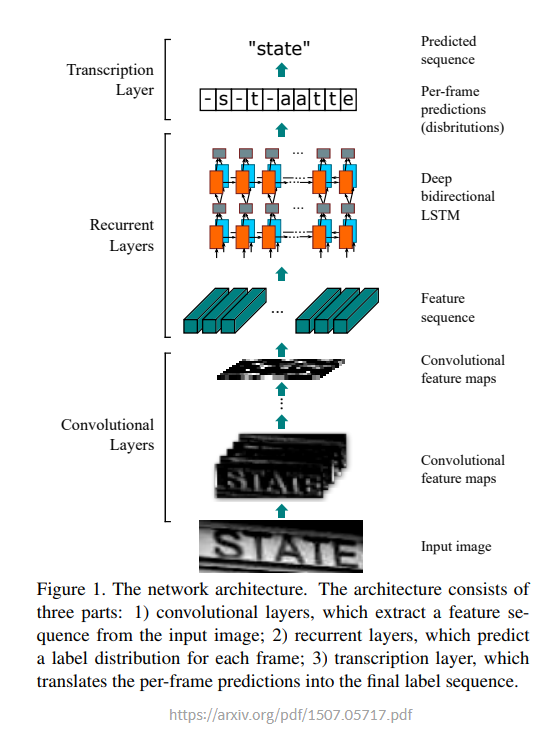  
  - CRNN의 구조는 위 그림에서 아래부터 올라가는 순서  
  - 입력이미지를 Convolution Layer를 통해 Feature를 추출하여 추출된 Feature를 얻어냄  
  - Recurrent Layer는 추출된 Feature의 전체적인 Context를 파악하고  
    다양한 output의 크기에 대응 가능함  
  - 끝으로 Transcription layer(Fully connected layer)는 step마다  
    어떤 character의 확률이 높은지 예측함  
  - 정확한 구조  
  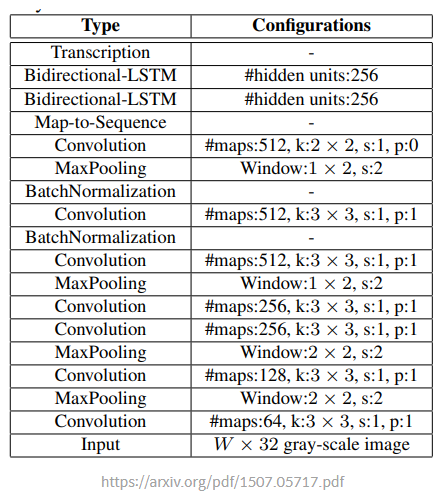  
  
 - 그럼 몇개의 class가 필요할까 확인해보자  

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


-> 영문의 대문자, 숫자 인식하기 위해서는 총 36가지 class가 필요  
   문자가 없는 경우 대비해 공백 추가하면, 총 37개  
   
   
- lmdb를 이용할 예정  
  -> LMDB? : Symas에서 만든 Lightning Memory-Mapped Database의 약자  
  -> 다루게 될 데이터셋이 lmdb 포맷(mdb)의 파일로 이루어져 있음  

In [3]:
! pip install lmdb  

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# 필요한 라이브러리들을 import
# 다운로드한 MJ 데이터셋의 위치도 확인

import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


## 5. Recognition model (2) Input Image  
### step 2. 데이터셋 확인  

- 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해보자  
  1) lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape가 어떻게 생겼는지  
  2) 이미지나 라벨은 어떻게 달려 있는지를 확인  
  

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


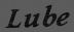

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


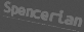

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


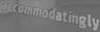

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


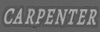

In [5]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- 대부분의 이미지의 height는 31, 최대 32까지  
  width는 문자열 길이에 따라 다양함  
  
### step 3. 케라스 모델 학습용 MJSynth데이터셋 클래스 생성  
- lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현  


In [6]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path, #dataset_path: 읽어들일 데이터셋의 경로
                 label_converter, #label_converter : 아래에서 문자를 미리정의된 index로 변환해주는 converter (직접 구현하기)
                 batch_size=1,
                 img_size=(100,32), #입력 이미지 크기
                 max_text_len=22, #필터링위한 최대 글자 수
                 is_train=False,
                 character='') : #학습대상으로 한정하기 위한 character
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

- 이미지 데이터를 img, label의 쌍으로 가져오고 있음  
  -> 이부분은 _get_img_label() 메소드에 반영되어 있음  


- _get_img_label() 를 통해 가져온 데이터셋을 리턴하는데  
   model.fit()에서 호출되는 __getitem__() 메소드에서 배치 단위만큼 리턴함  
   <- _get_img_label() 를 보면 다양한 사이즈의 이미지를  
   모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공하고 있음  

## 6. Recognition model (3) Encode  

### step 4. Label encode 함수 생성
- Label이 우리가 읽을 수 있는 평문 Text로 이루어져 있었음  
  -> 그러나 이것은 모델을 학습하기 위해서 적절한 형태가 아님  
  -> label은 구분지어 질 수 있는 class 형태로 존재해야함  
  -> 각 Character를 class로 생각하고  
  -> 이를 step에 따른 class index로 변환해서 encode를 해주어야함  
  -> LabelConverter 이름으로 클래스 생성해보자  
  
  
  - 모델 학습 데이터에 공백 문자를 넣고 있는데, 왜 포함되어야 하는지는  
    이후 설명  

In [10]:
class LabelConverter(object):
    #__init__에서  
    #입력으로 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장
    #character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어짐
    #만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2
    def __init__(self, character):
        self.character = "-" + character #공백(blank) 문자를 지정 : 공백 문자를 뜻하기 위해 '-'를 활용,  label은 0으로 지정
        self.label_map = dict()
        for i, char in enumerate(self.character):
             self.label_map[char] = i
    
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)
    
    #decode() 에서
    #각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줌
    def decode(self, encoded_label):
            target_characters = list(self.character)
            decoded_label = ""
            for encode in encoded_label:
                decoded_label += self.character[encode]
            return decoded_label

- 예시로  'HELLO'를 Encode후, Decode가 정상적으로 되는지 확인

In [11]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


-> 동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함되고 있음  

## 7. Recognition model (4) Build CRNN model  
- 입력, 출력을 했으니, 모델 생성해보자  
   Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss계산  
   -> ctc_lambda_func()으로 함수 생성  

In [13]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

-> CTC Loss 함수를 구현하기 위해 이 함수에 인자로 어떤 값을 넘겨야 할까?  
   [Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)  
   
- 여기서 잠시
   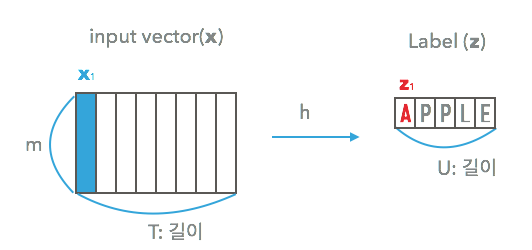  
   -> 지금 설명하고 있는 CTC Loss를 활용하려는  
   해당 프로젝트의 모델은 위 그림과 같은 상황을 다루기 위한 것  
   -> 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때는 어떻게 출력이 나올까?  
   -> 라벨은 APPLE이지만 모델이 출력한 결과는 AAAPPPPLLLLEE 처럼 나올 수 있음  
   -> 이런 상황이 이미지에서 텍스트 라벨을 추론해야 하는 Text recognition 태스크에 동일하게 적용됨  
   
   -> 그리고 이러한 상황 때문에 공백을 포함해서 처리해줌  
      = LabelConverter.encode() 메소드에 공백문자 처리로직을 포함시킴
     (모델이 AAAPPPPLLLLEE을 출력 경우,  
     추론 결과는 APLE, APPLE 둘중에 APLE로 결론을 내리게 됨  
     그러므로 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해줌  
     그래서 모델이 AAAPP-PPLLLEE로 출력을 한다면 추론 결과는 APPLE이 되는 것)  
     

- 다시 돌아가서 CTC Loss 함수의 인자에 대해서 알아보자  
  [Tensorflow Tutorial - ctc_batch_cost](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)  
  위 텐서플로우 튜토리얼을 보면 K.ctc_batch_cost(y_true, y_pred, input_length, label_length)에는 4가지 인자가 존재  
  - 1) y_true: tensor (samples, max_string_length) containing the truth labels  
  - 2) y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax  
  - 3)input_length tensor: (samples, 1) containing the sequence length for each batch item in y_pred  
  - 4) label_length tensor: (samples, 1) containing the sequence length for each batch item in y_true  
  <- 여기서 samples = 배치 사이즈  

- 우리가 가지고 있는 실제 데이터셋으로 본다면    
  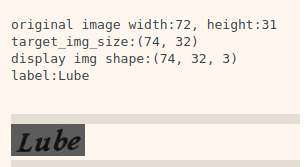  
  1) y_true: 실제 라벨 LUBE. 텍스트 라벨 그대로가 아니라,  
     각 글자를 One-hot 인코딩한 형태로서, max_string_length 값은 모델에서 22로 지정할 예정  
  2) y_pred: 우리가 만들 RCNN 모델의 출력 결과  
     길이는 4가 아니라 우리가 만들 RNN의 최종 출력 길이로서 24가 될 예정  
  3) input_length tensor: 모델 입력 길이 T로서,  
     이 경우에는 텍스트의 width인 74  
  4) label_length tensor: 라벨의 실제 정답 길이 U로서, 이 경우에는 4  

### step 5. 최종 CRNN 모델생성  
- K.ctc_batch_cost()를 활용하여,  
  image_input을 입력으로,  
  마지막 Label을 'output'이라는 이름으로 출력하는  
  레이어를 갖도록 모델을 만드는 함수  
  = build_crnn_model() 구현해보기  

In [15]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

## 8. Recognition model (5) Train & Inference

### step 6. 1 epoch 학습  
- 이제 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된  
  데이터셋을 통해 학습  
  -> 학습 오래걸리니까 예시로 1 Epoch만 학습  
  

In [42]:
# 데이터셋, 모델 준비
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델 컴파일
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [43]:
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping 사용
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=4, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/20
565/565 [==============================] - 165s 279ms/step - loss: 27.5893 - val_loss: 23.1823

Epoch 00001: val_loss improved from inf to 23.18232, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 155s 274ms/step - loss: 18.4852 - val_loss: 9.3549

Epoch 00002: val_loss improved from 23.18232 to 9.35489, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 158s 280ms/step - loss: 7.7713 - val_loss: 6.4196

Epoch 00003: val_loss improved from 9.35489 to 6.41962, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 155s 273ms/step - loss: 5.3248 - val_loss: 5.2077

Epoch 00004: val_loss improved from 6.41962 to 5.20772, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 157s 277ms/step - loss: 4.1148 - val_loss: 4.5958

Epoch 00005: val_loss 

- 위에서 학습된 모델을 테스트셋을 통해 확인  

In [44]:
# 다음은 학습된 모델의 가중치가 저장된 경로
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)


# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수 없음
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 생성
# 즉 inference 전용 모델 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

- 학습된 모델의 성능 시각화해서 확인  

Result: 	 SLINKING9999999999999999


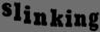

Result: 	 ALEPPO99999999999999999


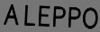

Result: 	 IWANDA999999999999999999


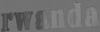

Result: 	 NATHANS99999999999999999


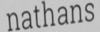

Result: 	 HALLD999999999999999999


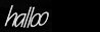

Result: 	 HURLS9999999999999999999


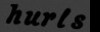

Result: 	 DOWNSIZE9999999999999999


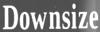

Result: 	 ROBOTIC9999999999999999


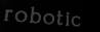

Result: 	 SLOPPY99999999999999999


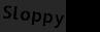

Result: 	 HERMITE99999999999999999


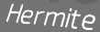

In [45]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있음 
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줌
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

## 9. 프로젝트: End-to-End OCR  

### step1. 라이브러리 버전 확인

In [46]:
import tensorflow as tf
import numpy as np
import PIL
import cv2

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)

2.4.1
1.19.5
8.1.0
4.5.1


### step2. 데이터 다운로드(☁️ aiffel 클라우드 유저용)  
- step3에서 심볼릭 링크를 사용  
  -> sample.jpg는 ~/aiffel/ocr/data디렉토리에 있음  

In [47]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


- keras OCR의 Detector class를 이용해서  
  이미지 내의 문자 위치를 찾아내는 함수 생성

In [48]:
from PIL import Image, ImageDraw
from IPython.display import display

def detect_text(img_path):
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, : ]# 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경
    det_result = detector.detect(img.numpy())
    ocr_result = det_result[0] # 배치의 첫 번째 결과만 가져옴
    
     # 시각화를 위해서 x와 y좌표를 변경 (앞선 h dimension으로 인해 y,x로 표기됨)
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

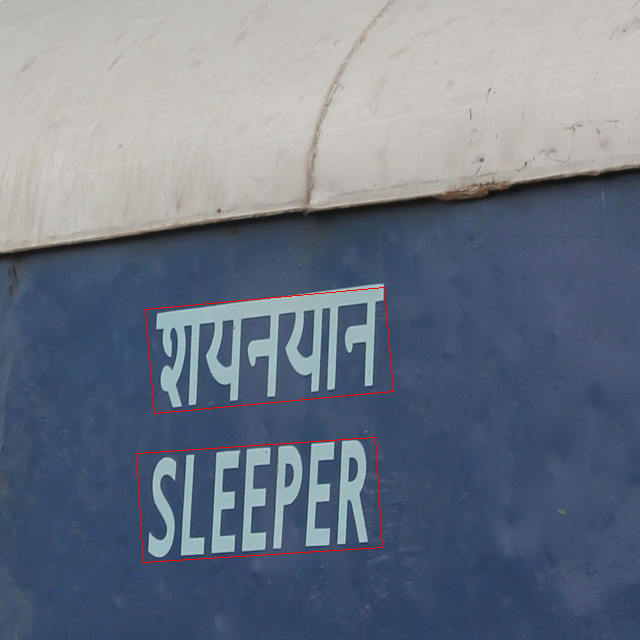

In [49]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

In [50]:
def recognize_img(pil_img, input_img_size=(100,32)):
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 ITAIFI9999999999999999


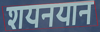

Result: 	 ISLEEPER999999999999999


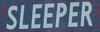

In [51]:
for _img in cropped_img:
    recognize_img(_img)

### 💚루브릭  
1. Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었는가?  
텍스트 이미지 리사이징,  
ctc loss 측정을 위한 라벨 인코딩,  
배치처리 등이 적절히 수행됨 


2. CRNN 기반의 recognition 모델의 학습이 정상적으로 진행되었는가?  
학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확함  


3. keras-ocr detector와 CRNN recognizer를 엮어  
   원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었는가?  
   샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수 생성함  
   
### 💚 회고  
- 해커톤에서 진행하고자 하는 semantic segmentaion에서도  
  이미지를 numpy 형태로 바꾼 이후에 ocr 처럼  encode, decode 과정을  
  동일하게 진행하고 있어서 더 재밌고 쉽게 공부할 수 있었음  

- 20 epoch만 학습하는데도 꽤나 결과가 좋아서 신기함  

### 💚 참고 자료  
1) [yeonkkk님 github](https://github.com/yeonkkk/AIFFEL-Project/blob/main/GoingDeeper06/%5BGD6%5D%20End_to_End_OCR.ipynb)  
2) [ChloeS31님 github](https://github.com/ChloeS31/AIFFEL_GoingDeeper/blob/main/going_deeper_12/gd12.ipynb)  
3) [ImageDraw Module](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html)  
4) [이전 OCR 설명](https://github.com/ga0808/aiffel_GoingDeeper_CV/tree/main/%5BCV-11%5D/OCR)